In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
olors = {
    'SymphonyLMC': sns.color_palette("colorblind")[4],
    'SymphonyMilkyWay': sns.color_palette("colorblind")[0],
    'SymphonyGroup': sns.color_palette("colorblind")[2],
    'SymphonyLCluster': sns.color_palette("colorblind")[1],
    'SymphonyCluster': sns.color_palette("colorblind")[3]
}

In [ ]:
def plot_combined_ppsd_and_slopes(base_dir, suite_names):
    from matplotlib import gridspec

    fig_ppsd = plt.figure(figsize=(14, 12), dpi=500)
    gs_ppsd = gridspec.GridSpec(3, 2, height_ratios=[3, 3, 1])
    ax_ppsd = [fig_ppsd.add_subplot(gs_ppsd[0, 0]),
               fig_ppsd.add_subplot(gs_ppsd[0, 1]),
               fig_ppsd.add_subplot(gs_ppsd[1, 0]),
               fig_ppsd.add_subplot(gs_ppsd[1, 1])]
    ax_resid = [fig_ppsd.add_subplot(gs_ppsd[2, 0]),
                fig_ppsd.add_subplot(gs_ppsd[2, 1])]

    fig_slope, axes_slope = plt.subplots(2, 2, figsize=(14, 10), dpi=500)
    ax_slope = axes_slope.flatten()

    interp_m = np.logspace(-4, 0, 200)

    def load_ppsd_profiles(suite):
        dir_path = os.path.join(base_dir, "output", suite, "ppsd_profiles")
        files = sorted([f for f in os.listdir(dir_path) if f.endswith(".csv")])
        r_list, m_list, Qr_list, Qtot_list = [], [], [], []
        for f in files:
            df = pd.read_csv(os.path.join(dir_path, f))
            r_list.append(df["r_scaled"].values)
            m_list.append(df["m_scaled"].values)
            Qr_list.append(df["Q_r"].values)
            Qtot_list.append(df["Q_tot"].values)
        return r_list, m_list, Qr_list, Qtot_list

    def load_slope_profiles(suite):
        dir_r = os.path.join(base_dir, "output", suite, "ppsd_slope_profiles_r")
        dir_m = os.path.join(base_dir, "output", suite, "ppsd_slope_profiles_m")
        files_r = sorted([f for f in os.listdir(dir_r) if f.endswith(".csv")])
        files_m = sorted([f for f in os.listdir(dir_m) if f.endswith(".csv")])
        r_list, m_list, slope_r_Qr, slope_r_Qtot, slope_m_Qr, slope_m_Qtot = [], [], [], [], [], []
        for fr, fm in zip(files_r, files_m):
            dfr = pd.read_csv(os.path.join(dir_r, fr))
            dfm = pd.read_csv(os.path.join(dir_m, fm))
            r_list.append(dfr["r_scaled"].values)
            m_list.append(dfm["m_scaled"].values)
            slope_r_Qr.append(dfr["slope_Q_r"].values)
            slope_r_Qtot.append(dfr["slope_Q_tot"].values)
            slope_m_Qr.append(dfm["slope_Q_r"].values)
            slope_m_Qtot.append(dfm["slope_Q_tot"].values)
        return r_list, m_list, slope_r_Qr, slope_r_Qtot, slope_m_Qr, slope_m_Qtot

    def interpolate_curves(x_target, x_list, y_list):
        return np.array([
            np.interp(x_target, x, y, left=np.nan, right=np.nan)
            for x, y in zip(x_list, y_list)
            if np.all(np.isfinite(x)) and np.all(np.isfinite(y))
        ])

    Qr_all_r, Qtot_all_r, r_all = [], [], []

    for suite in suite_names:
        color = sim_colors.get(suite, "gray")
        r_list, m_list, Qr_list, Qtot_list = load_ppsd_profiles(suite)

        # Use radius directly without interpolation
        Qr_all_r.extend(Qr_list)
        Qtot_all_r.extend(Qtot_list)
        r_all = r_list[0]  # Assuming aligned

        Qr_arr = np.array(Qr_list)
        Qtot_arr = np.array(Qtot_list)

        for ax, data in zip(ax_ppsd[:2], [Qr_arr, Qtot_arr]):
            mean = np.nanmean(data, axis=0)
            std = np.nanstd(data, axis=0)
            ax.plot(r_list[0], mean, color=color, label=suite)
            ax.fill_between(r_list[0], mean - std, mean + std, color=color, alpha=0.3)

        Qr_interp_m = interpolate_curves(interp_m, m_list, Qr_list)
        Qtot_interp_m = interpolate_curves(interp_m, m_list, Qtot_list)

        for ax, data in zip(ax_ppsd[2:], [Qr_interp_m, Qtot_interp_m]):
            mean = np.nanmean(data, axis=0)
            std = np.nanstd(data, axis=0)
            ax.plot(interp_m, mean, color=color, label=suite)
            ax.fill_between(interp_m, mean - std, mean + std, color=color, alpha=0.3)

        r_slope, m_slope, sr_Qr, sr_Qtot, sm_Qr, sm_Qtot = load_slope_profiles(suite)

        slope_interp_m_Qr = interpolate_curves(interp_m, m_slope, sm_Qr)
        slope_interp_m_Qtot = interpolate_curves(interp_m, m_slope, sm_Qtot)

        for i, (interp, x_vals) in enumerate(zip(
            [sr_Qr, sr_Qtot, slope_interp_m_Qr, slope_interp_m_Qtot],
            [r_list[0], r_list[0], interp_m, interp_m])):
            data = np.array(interp)
            mean = np.nanmean(data, axis=0)
            std = np.nanstd(data, axis=0)
            ax_slope[i].plot(x_vals, mean, color=color, label=suite)
            ax_slope[i].fill_between(x_vals, mean - std, mean + std, color=color, alpha=0.3)

        mean_Qr = np.nanmean(Qr_arr, axis=0)
        mean_Qtot = np.nanmean(Qtot_arr, axis=0)
        A_r = np.exp(np.nanmean(np.log(mean_Qr) + 1.875 * np.log(r_list[0])))
        A_tot = np.exp(np.nanmean(np.log(mean_Qtot) + 1.875 * np.log(r_list[0])))
        ref_Qr = A_r * r_list[0]**(-1.875)
        ref_Qtot = A_tot * r_list[0]**(-1.875)

        resid_Qr = np.log10(Qr_arr / ref_Qr)
        resid_Qtot = np.log10(Qtot_arr / ref_Qtot)

        ax_resid[0].plot(r_list[0], np.nanmean(resid_Qr, axis=0), color=color, label=suite)
        ax_resid[1].plot(r_list[0], np.nanmean(resid_Qtot, axis=0), color=color, label=suite)
        
    labels = ["$Q_r$ vs $r$", "$Q_{tot}$ vs $r$", "$Q_r$ vs $M$", "$Q_{tot}$ vs $M$"]
    for i, ax in enumerate(ax_ppsd):
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel("r / $R_{vir}$" if i < 2 else "M(<r) / $M_{vir}$")
        ax.set_ylabel("Q")
        ax.set_title(labels[i])
        ax.grid(True, which="both", linestyle=":")
        ax.legend()

    for ax in ax_resid:
        ax.set_xscale("log")
        ax.set_xlabel("r / $R_{vir}$")
        ax.set_ylabel("log$_{10}$(residual)")
        ax.grid(True, which="both", linestyle=":")


    for i, ax in enumerate(ax_slope):
        ax.set_xscale("log")
        ax.set_xlabel("r / $R_{vir}$" if i < 2 else "M(<r) / $M_{vir}$")
        ax.set_ylabel("Slope")
        ax.set_title(labels[i])
        ax.grid(True, which="both", linestyle=":")
        ax.axhline(-1.875, color="black", lw=0.9, ls="--")
        ax.legend()

    fig_ppsd.suptitle("PPSD Profiles with Residuals: Mean ± 1σ across Suites", fontsize=16)
    fig_slope.suptitle("PPSD Slope Profiles: Mean ± 1σ across Suites", fontsize=16)

    out_dir = os.path.join(base_dir, "output", "Combined")
    os.makedirs(out_dir, exist_ok=True)
    fig_ppsd.tight_layout(rect=[0, 0, 1, 0.96])
    fig_slope.tight_layout(rect=[0, 0, 1, 0.96])
    fig_ppsd.savefig(os.path.join(out_dir, "ppsd_profiles_comparison_with_residuals.png"))
    fig_slope.savefig(os.path.join(out_dir, "ppsd_slope_profiles_comparison.png"))
    plt.show()

base_dir = "/Users/fengbocheng/Projects/Symphony-PPSD"
suite_names = [
    "SymphonyLMC",
    "SymphonyMilkyWay",
    "SymphonyGroup",
    "SymphonyLCluster",
    "SymphonyCluster",
]

plot_combined_ppsd_and_slopes(base_dir, suite_names)

In [49]:
import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2

def chi_squared_between_suites(
    base_dir,
    suite_names,
    quantity="Q_r",       # Options: "Q_r", "Q_tot", "slope_Q_r", "slope_Q_tot"
    coord="r",            # "r" = radius; "m" = enclosed mass
    x_range=None,         # Tuple (xmin, xmax) to limit the x-range for comparison
    n_points=100,         # Number of interpolation points on common grid
    plot=True,            # If True, show comparison plots
):
    x_key = "r_scaled" if coord == "r" else "m_scaled"
    is_slope = quantity.startswith("slope_")
    suite_data = {}
    global_x_min = np.inf
    global_x_max = -np.inf

    for suite in suite_names:
        x_stack, y_stack = [], []

        if is_slope:
            slope_dir = os.path.join(base_dir, "output", suite, f"ppsd_slope_profiles_{coord}")
            files = sorted(f for f in os.listdir(slope_dir) if f.endswith(".csv") and f.startswith("halo_"))

            for f in files:
                try:
                    df = pd.read_csv(os.path.join(slope_dir, f))
                    if x_key not in df.columns or quantity not in df.columns:
                        continue
                    x = df[x_key].values
                    y = df[quantity].values
                    x_stack.append(x)
                    y_stack.append(y)

                    valid_x = x[np.isfinite(x)]
                    if valid_x.size > 0:
                        global_x_min = min(global_x_min, valid_x.min())
                        global_x_max = max(global_x_max, valid_x.max())
                except Exception as e:
                    print(f"[Warning] Failed to read slope {f}: {e}")
                    continue
        else:
            profile_dir = os.path.join(base_dir, "output", suite, "ppsd_profiles")
            files = sorted(f for f in os.listdir(profile_dir) if f.endswith(".csv"))

            for f in files:
                df = pd.read_csv(os.path.join(profile_dir, f))
                if x_key not in df.columns or quantity not in df.columns:
                    continue
                x = df[x_key].values
                y = df[quantity].values
                x_stack.append(x)
                y_stack.append(y)

                valid_x = x[np.isfinite(x)]
                if valid_x.size > 0:
                    global_x_min = min(global_x_min, valid_x.min())
                    global_x_max = max(global_x_max, valid_x.max())

        if len(x_stack) == 0:
            raise RuntimeError(f"No valid profiles found for suite {suite}")

        suite_data[suite] = {"x_stack": x_stack, "y_stack": y_stack}

    # Step 2: Interpolation grid
    xmin, xmax = x_range
    
    x_common = np.logspace(np.log10(xmin), np.log10(xmax), n_points)
    # Step 3: Interpolate and average
    for suite in suite_names:
        y_interp_all = []
        for x_arr, y_arr in zip(suite_data[suite]["x_stack"], suite_data[suite]["y_stack"]):
            y_interp = np.interp(x_common, x_arr, y_arr, left=np.nan, right=np.nan)
            y_interp_all.append(y_interp)
        y_interp_all = np.array(y_interp_all)

        suite_data[suite]["x"] = x_common
        suite_data[suite]["mean"] = np.nanmean(y_interp_all, axis=0)
        suite_data[suite]["std"] = np.nanstd(y_interp_all, axis=0)

    # Step 4: χ² test
    results = {}
    for s1, s2 in itertools.combinations(suite_names, 2):
        d1, d2 = suite_data[s1], suite_data[s2]
        x = d1["x"]
        μ1, σ1 = d1["mean"], d1["std"]
        μ2, σ2 = d2["mean"], d2["std"]

        valid = np.isfinite(μ1) & np.isfinite(μ2) & (σ1 + σ2 > 0)
        if x_range is not None:
            valid &= (x >= xmin) & (x <= xmax)

        ν = np.sum(valid)
        if ν < 5:
            print(f"[Warning] Too few valid points for {s1} vs {s2}")
            continue

        χ2_val = np.sum((μ1[valid] - μ2[valid])**2 / (σ1[valid]**2 + σ2[valid]**2))
        p_val = 1 - chi2.cdf(χ2_val, ν)

        results[(s1, s2)] = {"chi2": χ2_val, "dof": ν, "pval": p_val}

        if plot:
            plt.figure(figsize=(6, 4), dpi=400)
            plt.errorbar(x[valid], μ1[valid], yerr=σ1[valid], fmt="-o", label=s1, markersize=3, capsize=2)
            plt.errorbar(x[valid], μ2[valid], yerr=σ2[valid], fmt="-s", label=s2, markersize=3, capsize=2)
            plt.xscale("log")
            plt.xlabel(f"{coord.upper()} (scaled)")
            plt.ylabel(quantity)
            plt.title(f"{s1} vs {s2}  |  χ²={χ2_val:.1f}, ν={ν}, p={p_val:.3g}")
            plt.grid(True, which="both", ls=":")
            plt.legend()
            plt.tight_layout()
            plt.show()

    return results

In [ ]:
base_dir = "/Users/fengbocheng/Projects/Symphony-PPSD"
suite_names = [
    "SymphonyLMC",
    "SymphonyMilkyWay",
    "SymphonyGroup",
    "SymphonyLCluster",
    "SymphonyCluster",
]

chi_squared_between_suites(
    base_dir,
    suite_names,
    quantity="slope_Q_r",
    coord="m",
    x_range=(1e-3, 1.0), 
    n_points=100,
)

In [54]:
def ks_test_profilewise_between_suites_with_significance(
    base_dir,
    suite_names,
    quantity="Q_r",
    coord="r",
    x_range=None,
    n_points=100,
    plot=True,
    significance_levels=[0.05, 0.01]  # Mark thresholds for statistical significance
):
    x_key = "r_scaled" if coord == "r" else "m_scaled"
    is_slope = quantity.startswith("slope_")
    suite_data = {}
    global_x_min = np.inf
    global_x_max = -np.inf

    for suite in suite_names:
        x_stack, y_stack = [], []

        if is_slope:
            slope_dir = os.path.join(base_dir, "output", suite, f"ppsd_slope_profiles_{coord}")
            files = sorted(f for f in os.listdir(slope_dir) if f.endswith(".csv") and f.startswith("halo_"))
        else:
            profile_dir = os.path.join(base_dir, "output", suite, "ppsd_profiles")
            files = sorted(f for f in os.listdir(profile_dir) if f.endswith(".csv"))

        for f in files:
            try:
                path = os.path.join(slope_dir if is_slope else profile_dir, f)
                df = pd.read_csv(path)
                if x_key not in df.columns or quantity not in df.columns:
                    continue
                x = df[x_key].values
                y = df[quantity].values
                x_stack.append(x)
                y_stack.append(y)
                valid_x = x[np.isfinite(x)]
                if valid_x.size > 0:
                    global_x_min = min(global_x_min, valid_x.min())
                    global_x_max = max(global_x_max, valid_x.max())
            except Exception as e:
                print(f"[Warning] Failed to read {f}: {e}")
                continue

        if len(x_stack) == 0:
            raise RuntimeError(f"No valid profiles found for suite {suite}")

        suite_data[suite] = {"x_stack": x_stack, "y_stack": y_stack}

    if x_range is None:
        xmin, xmax = global_x_min, global_x_max
    else:
        xmin, xmax = x_range

    x_common = np.logspace(np.log10(xmin), np.log10(xmax), n_points)

    for suite in suite_names:
        y_interp_all = []
        for x_arr, y_arr in zip(suite_data[suite]["x_stack"], suite_data[suite]["y_stack"]):
            y_interp = np.interp(x_common, x_arr, y_arr, left=np.nan, right=np.nan)
            y_interp_all.append(y_interp)
        suite_data[suite]["y_interp_all"] = np.array(y_interp_all)

    results = {}
    for s1, s2 in itertools.combinations(suite_names, 2):
        y1_all = suite_data[s1]["y_interp_all"]
        y2_all = suite_data[s2]["y_interp_all"]

        ks_stats = []
        p_values = []
        for i in range(n_points):
            v1 = y1_all[:, i]
            v2 = y2_all[:, i]
            v1 = v1[np.isfinite(v1)]
            v2 = v2[np.isfinite(v2)]

            if len(v1) < 5 or len(v2) < 5:
                ks_stats.append(np.nan)
                p_values.append(np.nan)
                continue

            ks_stat, p_val = ks_2samp(v1, v2)
            ks_stats.append(ks_stat)
            p_values.append(p_val)

        ks_stats = np.array(ks_stats)
        p_values = np.array(p_values)

        results[(s1, s2)] = {
            "x": x_common,
            "ks_stat": ks_stats,
            "pval": p_values,
        }

        if plot:
            fig, ax1 = plt.subplots(figsize=(8, 4), dpi=150)
            ax1.plot(x_common, ks_stats, label="KS statistic", color="tab:blue", lw=2)
            ax1.set_xscale("log")
            ax1.set_xlabel(f"{coord.upper()} (scaled)")
            ax1.set_ylabel("KS statistic", color="tab:blue")
            ax1.tick_params(axis='y', labelcolor='tab:blue')
            ax1.grid(True, which="both", ls=":")

            ax2 = ax1.twinx()
            ax2.plot(x_common, p_values, label="p-value", color="tab:red", lw=1.8)
            for sig in significance_levels:
                ax2.axhline(sig, color="gray", ls="--", lw=0.8, label=f"p = {sig}")
            ax2.set_ylabel("p-value", color="tab:red")
            ax2.tick_params(axis='y', labelcolor='tab:red')
            ax2.set_yscale("log")

            lines, labels = ax1.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            ax2.legend(lines + lines2, labels + labels2, loc="upper right")

            plt.title(f"KS Test: {s1} vs {s2}")
            fig.tight_layout()
            plt.show()

    return results

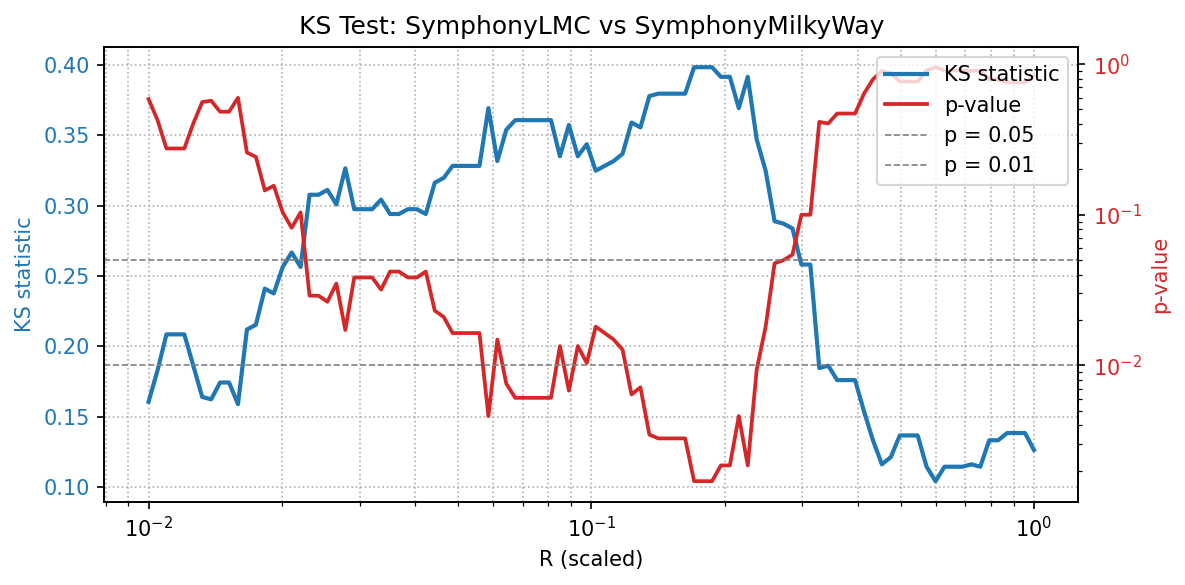

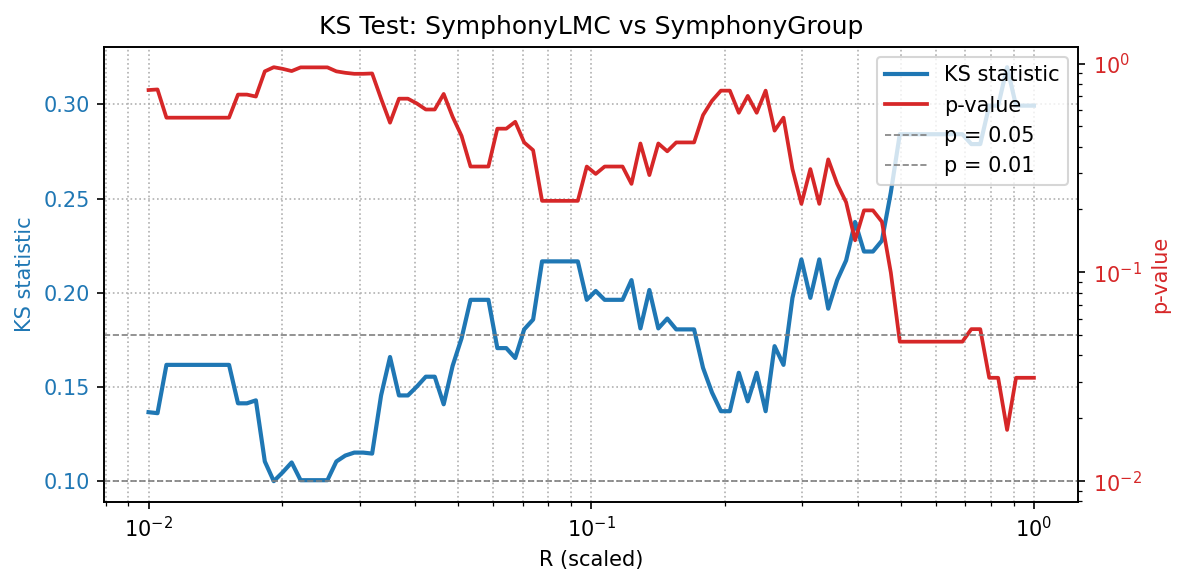

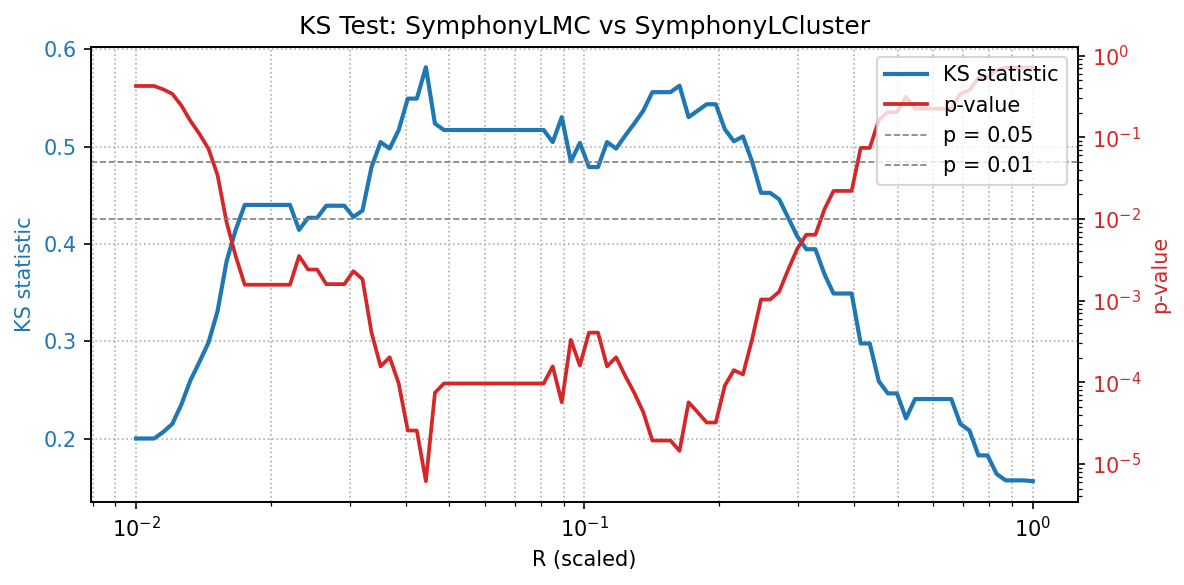

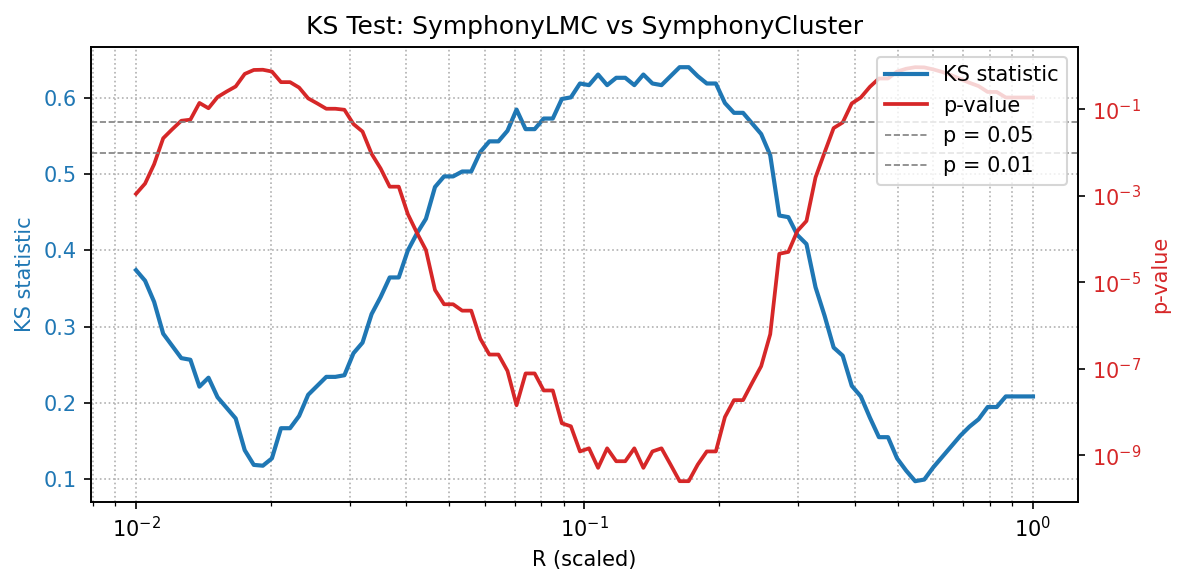

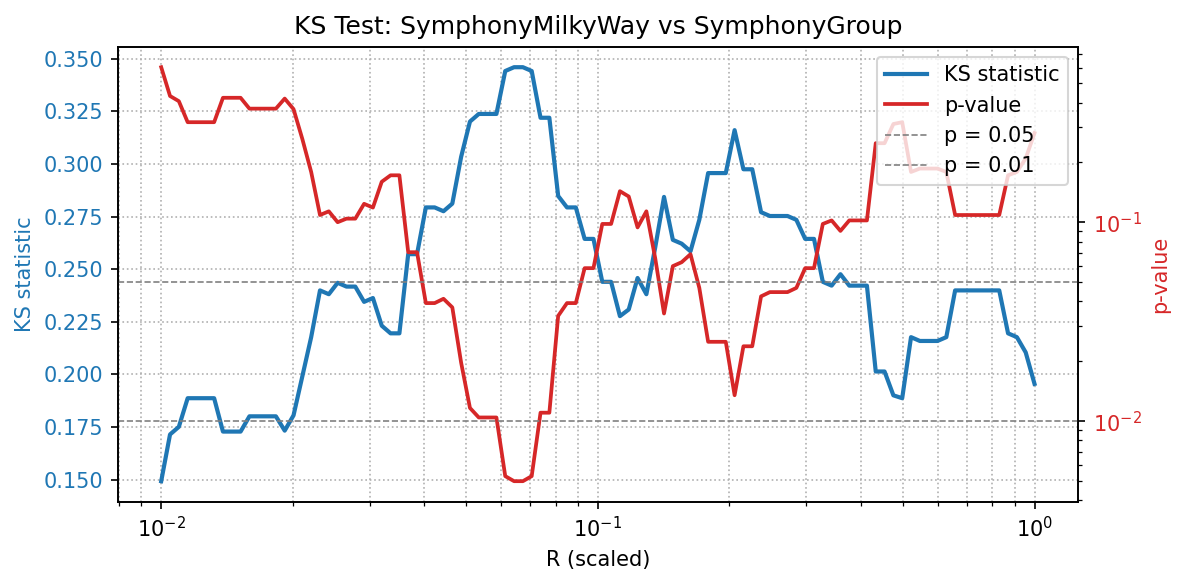

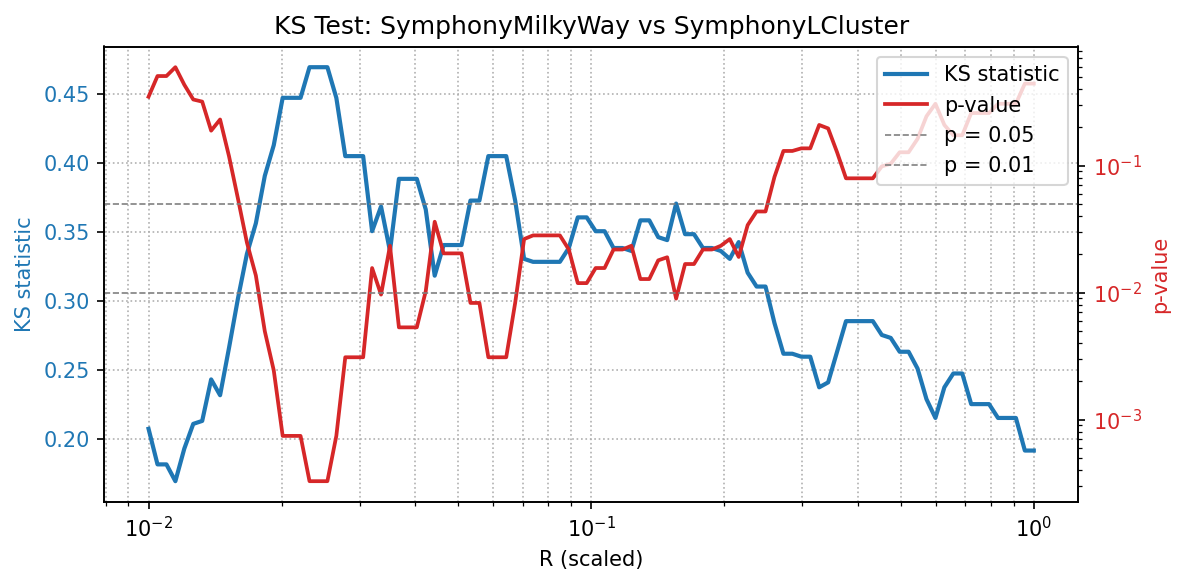

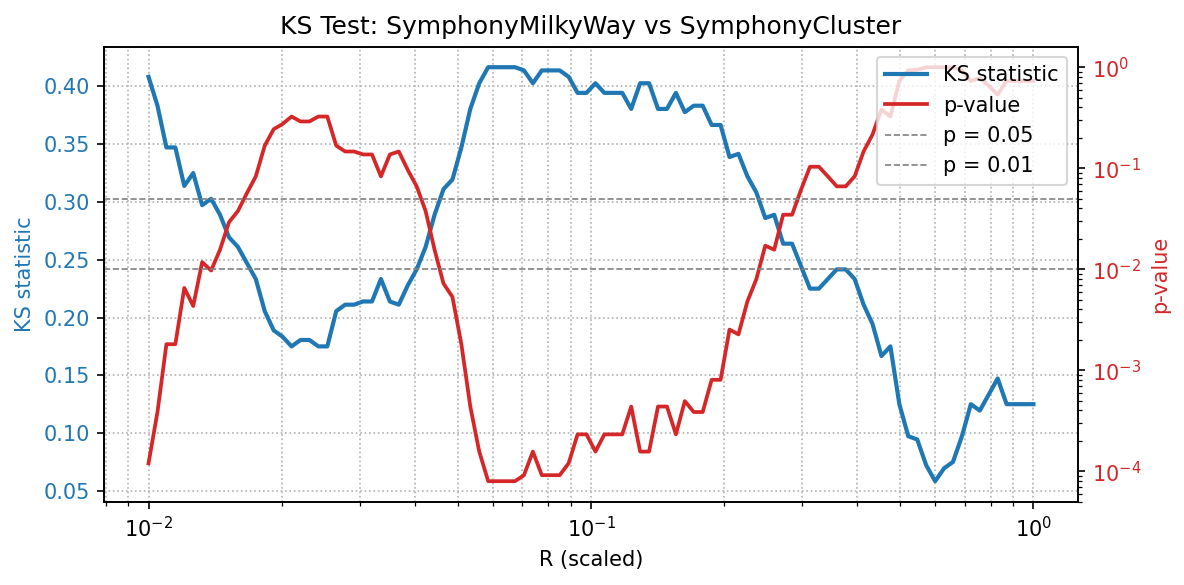

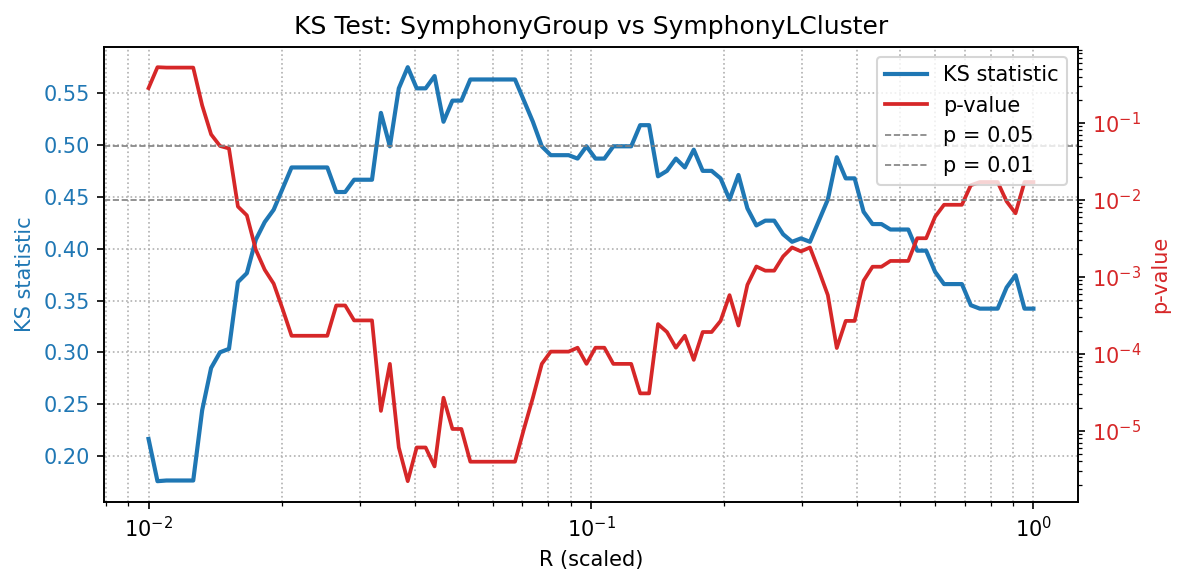

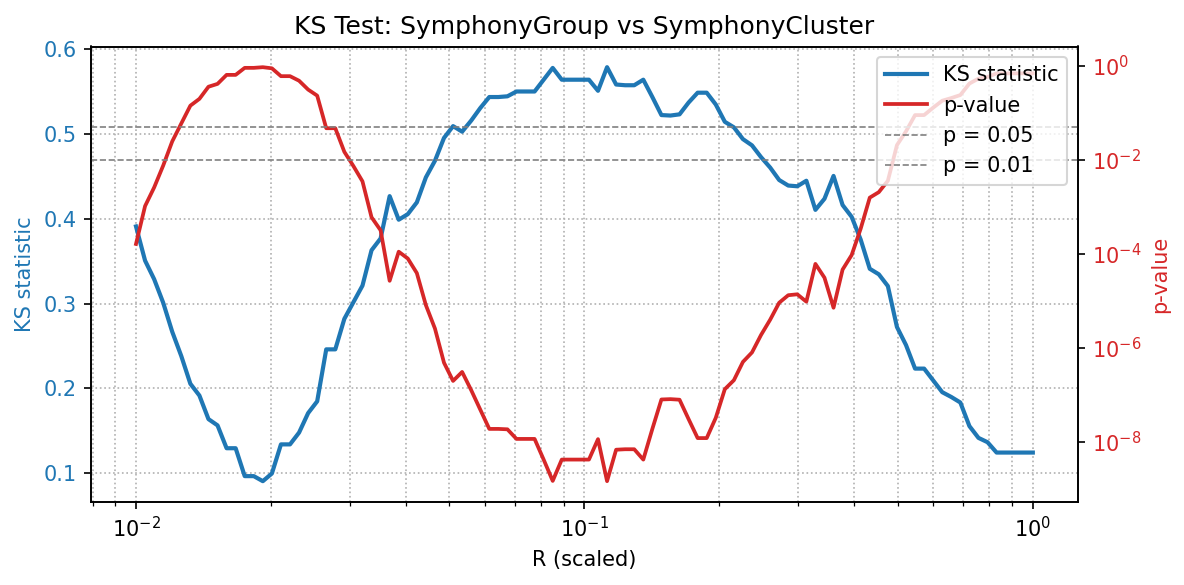

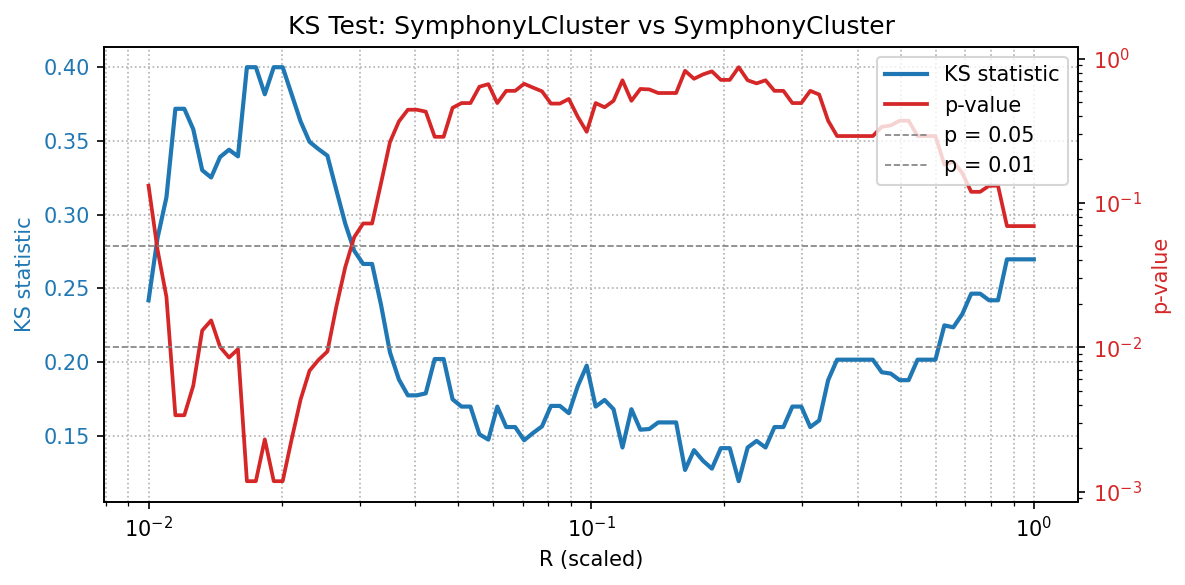

In [56]:
base_dir = "/Users/fengbocheng/Projects/Symphony-PPSD"
suite_names = [
    "SymphonyLMC",
    "SymphonyMilkyWay",
    "SymphonyGroup",
    "SymphonyLCluster",
    "SymphonyCluster",
]

results = ks_test_profilewise_between_suites_with_significance(
    base_dir,
    suite_names,
    quantity="slope_Q_r",
    coord="r",
    x_range=(0.01, 1),
    plot=True
)